In [1]:
# import necessary libraries
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
from matplotlib.patches import Rectangle
from math import sqrt

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

def my_get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  pred_class_num = pred_class_num[:pred_t+1]
  return masks, pred_boxes, pred_class_num

def my_get_person(img_path, threshold):
    masks, pred_boxes, pred_class_num = my_get_prediction(img_path, threshold)
    idx = 0
    idx_list = []
    masks_list = []
    pred_boxes_list = []
    pred_class_num_list = []
    #print(pred_class_num)
    for i in pred_class_num:
        #print(i)
        if i == 1 :
            #print(i)
            #idx_list.append(idx)
            masks_list.append(masks[idx])
            pred_boxes_list.append(pred_boxes[idx])
            pred_class_num_list.append(pred_class_num[idx])
        idx += 1
    return masks_list, pred_boxes_list, pred_class_num_list

def get_box_diag(box):
    return sqrt((box[0][0] - box[1][0])**2 + (box[0][1] - box[1][1])**2)

def my_get_person_bigest(img_path, threshold):
    masks_list, pred_boxes_list, pred_class_num_list = my_get_person(img_path, threshold)
    diag_list = []
    temp_list  = []
    for i in pred_boxes_list:
        diag_list.append(get_box_diag(i))
    temp_list = sorted(diag_list)
    ind_temp = len(temp_list)
    temp_max = temp_list[ind_temp - 1]
    index = diag_list.index(temp_max)
    return masks_list[index],pred_boxes_list[index],pred_class_num_list[index]
        
    

def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [355]:
masks, t , p  = my_get_person_bigest('look_3.jpeg', 0.9)
masks.shape

(1200, 960)

In [356]:
masks = masks
#masks = np.array(test[0][2])

In [357]:
### mask to image from func
### Get masks pixels color
#img_image = Image.open('../images.jpg')
img_image = Image.open('look_3.jpeg')
ar_image = np.asarray(img_image)
mask_list = []
for i in range(masks.size):
    #print(i)
    if masks.item(i):
        #print(i)
        x = i//masks.shape[1]
        y = i - x*masks.shape[1]
        #print(i,x,y)
        mask_list.append((x,y))
mask_list   

mask_ar_l = []
for i in mask_list:
    #ar_image[i[0]][i[1]]
    #img_tensor[0][i[0]][i[1]]
    mask_ar_l.append(ar_image[i[0]][i[1]])
mask_ar_ar = np.asarray(mask_ar_l)

#print(mask_ar_ar.size)
#print(ar_image.size)

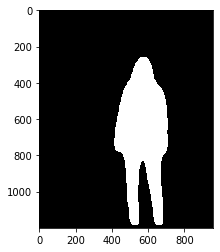

In [358]:
plt.imshow(masks, cmap='gray')
plt.show()

In [260]:
#img_image = Image.open('../images.jpg')
#img.getpixel((0,0))
#transform = T.Compose([T.ToTensor()])
#img_tensor = transform(img)
#pred = model([img_tensor])
#img_image.getpixel((0,0))

In [359]:
# Get look spectr by mask

from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

print('reading image')
im = Image.open('look_3.jpeg')
#im = Image.open('./shapki/shapka1-1.png')
#im = im.resize((150, 150))      # optional, to reduce time
##По картинке
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
######
## По маске
ar = mask_ar_ar.astype(float)
shape = ar.shape
#####

#print(ar,shape)


#ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
print(ar,shape)
print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

###
print('counts', counts)
###
index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))
### my block decode all colors
colour_test_list = []
for i in codes:
    colour_test = binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
    colour_test_list.append(colour_test)
#colour_test = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')

reading image
[[192. 184. 165.]
 [192. 184. 165.]
 [191. 183. 164.]
 ...
 [ 60.  61.  66.]
 [ 59.  60.  65.]
 [ 59.  60.  65.]] (172205, 3)
finding clusters
cluster centres:
 [[ 77.53197374  73.80650621  76.2502993 ]
 [ 33.47906742  36.52063835  44.8496189 ]
 [128.30305693 120.48540906 118.88253249]
 [222.53124383 218.57741199 216.84337214]
 [178.92510765 170.96375846 167.60339348]]
counts [24142 71724 21378 35485 19476]
most frequent is [33.47906742 36.52063835 44.8496189 ] (#21242c)


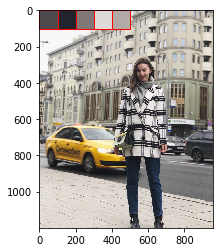

In [379]:
# Show look with spectr
im = Image.open('look_3.jpeg')
plt.imshow(im)
ax = plt.gca()
x = 0
y = 0
# Create a Rectangle patch
for i in colour_test_list:
    colors = str('#' + i )
    #x += 30
    #y = 100
    rect = Rectangle((x,y),100,100,linewidth=1,edgecolor='r',facecolor = colors)
    ax.add_patch(rect)
    x += 100

####

### get monolook by counts or no
####.....
### get monolook by colors or no
look_colors = []
for i in colour_test_list:
    look_color = PIL.ImageColor.getrgb(str('#'+ i))
    look_colors.append(look_color)
look_colors_lab = []
for item in look_colors:
    item = rgb2lab(item)
    look_colors_lab.append(item)
dist_colors_look = []
dist_colors_look_r = []
for item in look_colors_lab:
    for item2 in look_colors_lab:
        dist = euclidean(item,item2)
        dist_colors_look.append(dist)
    dist_colors_look_r.append(dist_colors_look[-5:])
    
### дальше сделать если моно, то по удаленности от одного основного цвета
### если не моно - ближний цвет по первым трем по вхождениям

In [ ]:
### Тут сравнение ####

In [361]:
### Цвета больших вхождений
tr = sorted(counts)[2:]
tr
#t = tr.fill(32584)
#tr.index(32584)
counts_list = counts.tolist()
idx_list = []
for i in tr:
    temp = counts_list.index(i)
    idx_list.append(temp)
idx_list

[0, 3, 1]

In [378]:
colour_test_list[idx_list[-1]]

'21242c'

In [362]:
### 1 цвета лука по count в LAB
look_most = rgb2lab(PIL.ImageColor.getrgb(str('#'+ colour_test_list[idx_list[-1]])))
look_most

[14.2131, 0.8555, -5.7489]

In [363]:
### 3 цвета лука по count
colour_test_list_3 = []
for i in idx_list:
    colour_test_list_3.append(colour_test_list[i])
colour_test_list_3

['4d494c', 'dedad8', '21242c']

In [364]:
### цвета шапок
f = open('shapka_colors-Copy1.txt', 'r')
colors_shapka_list = []
for line in f:
    #print(line)
    colors_shapka_list.append(line[:-1])
#a = f.read()
f.close()
colors_shapka_list

['#f5cfde', '#cec5c6', '#ed6551', '#9f0858', '#b2cdb8', '#ebdccf', '#5960a2']

In [365]:
### 3 цвета лука по count в rgb
look_colors = []
for i in colour_test_list_3:
    look_color = PIL.ImageColor.getrgb(str('#'+ i))
    look_colors.append(look_color)
look_colors

[(77, 73, 76), (222, 218, 216), (33, 36, 44)]

In [366]:
### цвета шапок в rgb
shapka_colors = []
for i in colors_shapka_list:
    shapka_color = PIL.ImageColor.getrgb(i)
    shapka_colors.append(shapka_color)
shapka_colors

[(245, 207, 222),
 (206, 197, 198),
 (237, 101, 81),
 (159, 8, 88),
 (178, 205, 184),
 (235, 220, 207),
 (89, 96, 162)]

In [377]:
# Расстояние от основного цвета
j = 0
#look_most = rgb2lab(counts_list[idx_list[-1]])
dist_l_1 = []
for shapka_i in shapka_colors:
    shapka_i = rgb2lab(shapka_i)
    dist = euclidean(shapka_i,look_most)
    dist_l_1.append(dist)
    print(shapka_i,dist_l_1[-1:],'\n')

[86.6584, 15.7223, -2.4375] [74.02910646691612] 

[80.2535, 3.3126, 0.6105] [66.39136797001551] 

[59.8037, 51.2472, 37.529] [80.56551908639328] 

[34.4966, 59.259, -3.0934] [61.8824762331793] 

[79.9475, -13.0768, 7.4148] [68.47191631859006] 

[88.6161, 2.9902, 8.2185] [75.73276448044136] 

[42.9108, 15.2163, -36.6354] [44.539493084003546] 



In [368]:
# Расстояние от 3 наиболее входящих цветов спектра
j = 0
dist_l = []
dist_l_l = []
res_shapka_list = []
for shapka_i in shapka_colors:
    shapka_i = rgb2lab(shapka_i)
    for i in look_colors:
        i = rgb2lab(i)
        dist = euclidean(shapka_i,i)
        dist_l.append(dist)
        j += 1
        if j % 3 == 0:
            #print(j)
            res_shapka = sum(dist_l[-3:])
    dist_l_l.append(dist_l[-3:])
    res_shapka_list.append(res_shapka)
    print(shapka_i,dist_l[-3:],'\n',res_shapka)

[86.6584, 15.7223, -2.4375] [56.783312839865204, 15.231006616110442, 74.02910646691612] 
 146.04342592289177
[80.2535, 3.3126, 0.6105] [48.80046498764126, 7.465503913333641, 66.39136797001551] 
 122.6573368709904
[59.8037, 51.2472, 37.529] [68.52905455819452, 67.68615539687566, 80.56551908639328] 
 216.78072904146347
[34.4966, 59.259, -3.0934] [57.064081189921914, 78.75433393496512, 61.8824762331793] 
 197.70089135806631
[79.9475, -13.0768, 7.4148] [51.55798175491358, 16.974472463378643, 68.47191631859006] 
 137.00437053688228
[88.6161, 2.9902, 8.2185] [57.89397465790374, 7.169084097707323, 75.73276448044136] 
 140.79582323605243
[42.9108, 15.2163, -36.6354] [39.406740197839255, 60.195009718995806, 44.539493084003546] 
 144.1412430008386


Ваша шапка по наименьшему расстоянию до одного № 5
Ваша шапка по наименьшему расстоянию до всех 3 цветов № 1
Ваша шапка по наименьшему расстоянию до основного цвета № 6


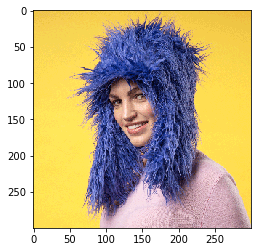

In [383]:
### Get results по наименьшему расстоянию до одного из 3 цветов
t = sorted(dist_l)
res = dist_l.index(t[0])//3
print('Ваша шапка по наименьшему расстоянию до одного №',res)
### Get results по наименьшему расстоянию до всех 3 цветов
t2 = sorted(res_shapka_list)
res2 = res_shapka_list.index(t2[0])
print('Ваша шапка по наименьшему расстоянию до всех 3 цветов №',res2)
#### Get results по наименьшему расстоянию до основного цвета
t3 = sorted(dist_l_1)
res3 = dist_l_1.index(t3[0])
print('Ваша шапка по наименьшему расстоянию до основного цвета №',res3)

#print
url = '../shapki/shapka' + str(res3+1) + '.png'
img = Image.open(url) # image extension *.png,*.jpg
new_width  = 300
new_height = 300
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('output_t.png') # format may what u want ,*.png,*jpg,*.gif
import imageio
shapka = imageio.imread('output_t.png')
type(shapka)      

shapka.shape, shapka.dtype
plt.imshow(shapka)


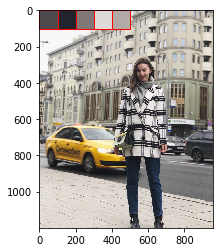

In [380]:
# Show look with spectr
im = Image.open('look_3.jpeg')
plt.imshow(im)
ax = plt.gca()
x = 0
y = 0
# Create a Rectangle patch
for i in colour_test_list:
    colors = str('#' + i )
    #x += 30
    #y = 100
    rect = Rectangle((x,y),100,100,linewidth=1,edgecolor='r',facecolor = colors)
    ax.add_patch(rect)
    x += 100

In [465]:
url = '../shapki/shapka' + str(res+1) + '.png'

In [395]:
# Расстояние от всех(5) цветов спектра
j = 0
dist_l = []
for shapka_i in shapka_colors:
    shapka_i = rgb2lab(shapka_i)
    for i in look_colors:
        i = rgb2lab(i)
        dist = euclidean(shapka_i,i)
        dist_l.append(dist)
        j += 1
        if j % 5 == 0:
            #print(j)
            res_shapka = sum(dist_l[-5:])
    print(shapka_i,dist_l[-5:],'\n',res_shapka)

[84.9136, 17.3622, -2.3613] [20.351152097854314, 69.37276901169507, 77.57158662867481] 
 320.09956428608683
[78.8842, 3.8634, -0.8898] [69.37276901169507, 77.57158662867481, 13.64210482366998, 67.16126210383482, 70.28147480353554] 
 248.09887466572897
[59.8037, 51.2472, 37.529] [67.16126210383482, 70.28147480353554, 72.27935070965981, 50.9486356489553, 78.18228421790963] 
 248.09887466572897
[35.353, 59.8562, -3.6991] [50.9486356489553, 78.18228421790963, 83.3334239480774, 92.84026146080159, 62.349964690046136] 
 355.0251693281377
[79.9475, -13.0768, 7.4148] [92.84026146080159, 62.349964690046136, 17.620155117648647, 63.33053277787895, 73.43588662915428] 
 309.57680067552957
[88.6161, 2.9902, 8.2185] [63.33053277787895, 73.43588662915428, 9.983148460280452, 60.05685106247247, 80.17557463629431] 
 309.57680067552957
[35.6906, 5.3489, -32.5651] [60.05685106247247, 80.17557463629431, 64.7455087901856, 105.13848133685401, 44.05911007158451] 
 320.09956428608683


In [ ]:
## Блок работы с md-картинками ##

In [214]:
url = '../shapki/shapka3.png'

In [215]:
# Resize шапок
img = Image.open(url) # image extension *.png,*.jpg
new_width  = 300
new_height = 300
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('output_t.png') # format may what u want ,*.png,*jpg,*.gif

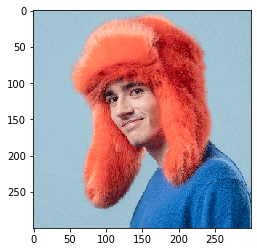

In [216]:
# Считываниеполученных png
import imageio
shapka = imageio.imread('output_t.png')
type(shapka)      

shapka.shape, shapka.dtype
plt.imshow(shapka)

In [117]:
img_image = Image.open(url)
#img.getpixel((0,0))
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
pred = model([img_tensor])
#img_image.getpixel((0,0))
pred

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>),
  'masks': tensor([], size=(0, 1, 300, 300))}]

In [118]:
masks = (pred[0]['masks']>0.1).squeeze().detach().cpu().numpy()
masks.shape
plt.imshow(masks[6], cmap='gray')
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 0

In [105]:
masks = masks[6]

In [119]:
### mask to image from func
### Get masks pixels color
#img_image = Image.open('../images.jpg')
img_image = Image.open(url)
ar_image = np.asarray(img_image)
mask_list = []
for i in range(masks.size):
    #print(i)
    if masks.item(i):
        #print(i)
        x = i//masks.shape[1]
        y = i - x*masks.shape[1]
        #print(i,x,y)
        mask_list.append((x,y))
mask_list   

mask_ar_l = []
for i in mask_list:
    #ar_image[i[0]][i[1]]
    #img_tensor[0][i[0]][i[1]]
    mask_ar_l.append(ar_image[i[0]][i[1]])
mask_ar_ar = np.asarray(mask_ar_l)

In [120]:
shapka_t0 = shapka[:,:,0:3]

reading image
finding clusters
cluster centres:
 [[251.41909411 218.13806334  83.16646611]
 [184.8143823  147.40493751 152.59004302]
 [230.06448718 197.44025641 206.92141026]
 [ 40.47567678  44.34446028  93.9683832 ]
 [ 89.3325033   96.40522924 162.51296323]]
most frequent is [251.41909411 218.13806334  83.16646611] (#fbda53)
the palitra ['fbda53', 'b89398', 'e6c5ce', '282c5d', '5960a2']


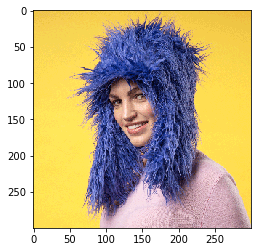

In [121]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

print('reading image')
im = Image.open(url)
im = Image.open('../shapki/shapka7.png')
#im = face_t0
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
################# My to png shapki start
#shape = ar.shape
shape = shapka_t0.shape
#print(ar,shape)
ar = shapka_t0 
############### My to png shapki stop
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
#print(ar,shape)
print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))
### my block decode all colors
colour_test_list = []
for i in codes:
    colour_test = binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
    colour_test_list.append(colour_test)
print('the palitra', colour_test_list)
#colour_test = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
plt.imshow(shapka)

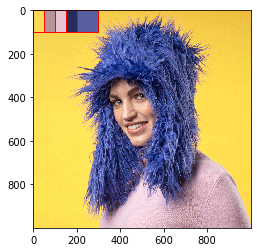

In [122]:
# Show look with spectr
im = Image.open(url)
plt.imshow(im)
ax = plt.gca()
x = 0
y = 0
# Create a Rectangle patch
for i in colour_test_list:
    colors = str('#' + i )
    #x += 30
    #y = 100
    rect = Rectangle((x,y),100,100,linewidth=1,edgecolor='r',facecolor = colors)
    ax.add_patch(rect)
    x += 50

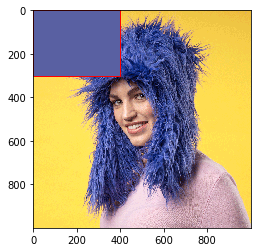

In [124]:
# Show look with spectr
number_color = 4

im = Image.open(url)
plt.imshow(im)
ax = plt.gca()
x = 0
y = 0
i = colour_test_list[number_color]
colors = str('#' + i )
    #x += 30
    #y = 100
rect = Rectangle((x,y),400,300,linewidth=1,edgecolor='r',facecolor = colors)
ax.add_patch(rect)
#x += 30

In [35]:
#colors_shapka_list = []

In [125]:
colors_shapka_list.append(colors)

In [126]:
colors_shapka_list

['#f5cfde', '#cec5c6', '#ed6551', '#9f0858', '#b2cdb8', '#ebdccf', '#5960a2']

In [127]:
# Запишем цвета и забудем работу с шапками
with open('shapka_colors.txt', 'w') as f:
    for item in colors_shapka_list:
        f.write("%s\n" % item)

In [158]:
f = open('shapka_colors-Copy1.txt', 'r')
colors_shapka_list = []
for line in f:
    print(line)
    colors_shapka_list.append(line[:-1])
#a = f.read()
f.close()

#f5cfde

#cec5c6

#ed6551

#9f0858

#b2cdb8

#ebdccf

#5960a2



In [159]:
colors_shapka_list

['#f5cfde', '#cec5c6', '#ed6551', '#9f0858', '#b2cdb8', '#ebdccf', '#5960a2']

In [151]:
a = f.read()
a.

'#f5cfde\n#cec5c6\n#ed6551\n#9f0858\n#b2cdb8\n#ebdccf\n#5960a2\n'

In [ ]:
#### Функции для подбора

In [165]:
# пространство lab в нем эвклидово расстояние соотвествует воспринимаемой человеком схожести цветов
def rgb2lab ( inputColor ) :

   num = 0
   RGB = [0, 0, 0]

   for value in inputColor :
       value = float(value) / 255

       if value > 0.04045 :
           value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
       else :
           value = value / 12.92

       RGB[num] = value * 100
       num = num + 1

   XYZ = [0, 0, 0,]

   X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
   Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
   Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
   XYZ[ 0 ] = round( X, 4 )
   XYZ[ 1 ] = round( Y, 4 )
   XYZ[ 2 ] = round( Z, 4 )

   XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
   XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
   XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883

   num = 0
   for value in XYZ :

       if value > 0.008856 :
           value = value ** ( 0.3333333333333333 )
       else :
           value = ( 7.787 * value ) + ( 16 / 116 )

       XYZ[num] = value
       num = num + 1

   Lab = [0, 0, 0]

   L = ( 116 * XYZ[ 1 ] ) - 16
   a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
   b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

   Lab [ 0 ] = round( L, 4 )
   Lab [ 1 ] = round( a, 4 )
   Lab [ 2 ] = round( b, 4 )

   return Lab

In [166]:
from math import sqrt
#Эвклидово
def euclidean(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    return sqrt(sum([
        (p1[i] - p2[i]) ** 2 for i in range(len(p1))
    ]))
# Какая-то формула
def some_strange(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    rmean = (p1[0] + p2[0])/2
    r = p1[0] - p2[0]
    g = p1[1] - p2[1]
    b = p1[2] - p2[2]
    return sqrt((2+(rmean/256))*(r**2) + 4*(g**2) + (2+(255-rmean)/256)*(b**2))